In [1]:
import pandas as pd
import numpy as np
import arviz as az

In [2]:
df_ethiopia = pd.read_excel(r'alldatasets.xlsx',sheet_name='Ethiopia')

In [3]:
df_ethiopia.head()

,childid,country,height,stunting_2cat,EDUYRS2,z_score,timeschool,agegapr1,momeduyrsr1,chsexr1,agemonr1,hhsizer1,wi_newr1,job_cat,pvt_sector,earn,earn_usd
0,ET011003,Ethiopia,157.0,0.0,16.5,1.379536,15.0,9.0,12.0,0,99,7,0.524603,5,1,2000.0,92.032104
1,ET011004,Ethiopia,174.0,NaN,10.0,-0.092591,30.0,10.0,6.0,1,90,8,0.473611,3,1,32000.0,1472.513672
2,ET011009,Ethiopia,155.0,0.0,12.5,1.785974,30.0,14.0,8.0,0,90,13,0.562821,5,1,7000.0,322.112366
3,ET011010,Ethiopia,153.5,0.0,12.0,1.803539,30.0,NaN,NaN,0,91,3,0.320370,5,1,3600.0,165.657791
4,ET011014,Ethiopia,169.0,0.0,10.0,0.893750,45.0,3.0,0.0,1,99,6,0.409259,3,1,43200.0,1987.893433


In [4]:
df_ethiopia.columns

Index(['childid', 'country', 'height', 'stunting_2cat', 'EDUYRS2', 'z_score',
       'timeschool', 'agegapr1', 'momeduyrsr1', 'chsexr1', 'agemonr1',
       'hhsizer1', 'wi_newr1', 'job_cat', 'pvt_sector', 'earn', 'earn_usd'],
      dtype='object')

In [5]:
from scipy import stats
import scipy.stats as stats

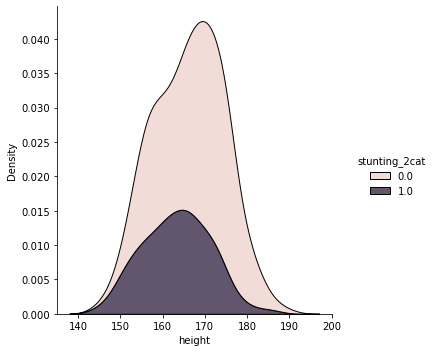

In [6]:
import seaborn as sns
sns.displot(df_ethiopia, x="height", hue="stunting_2cat", kind="kde", multiple="stack")

In [7]:
df_ethiopia=df_ethiopia.astype({"chsexr1": 'object', "job_cat": 'object', "pvt_sector": 'object',"stunting_2cat": 'object'})

In [8]:
df_outlier=df_ethiopia.copy()

In [9]:
total = df_outlier.isnull().sum().sort_values(ascending=False)
percent = (df_outlier.isnull().sum()/df_outlier.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Missing Percent'])
missing_data['Missing Percent'] = missing_data['Missing Percent'].apply(lambda x: x * 100)
missing_data.loc[missing_data['Missing Percent'] > 95]

,Total,Missing Percent


In [10]:
df_outlier=df_outlier.select_dtypes(include=['int64','floating'])

In [11]:
df_outlier.dtypes

height         float64
EDUYRS2        float64
z_score        float64
timeschool     float64
agegapr1       float64
momeduyrsr1    float64
agemonr1         int64
hhsizer1         int64
wi_newr1       float64
earn           float64
earn_usd       float64
dtype: object

In [12]:
import warnings

warnings.filterwarnings('ignore')

In [13]:
df_outlier.dtypes

height         float64
EDUYRS2        float64
z_score        float64
timeschool     float64
agegapr1       float64
momeduyrsr1    float64
agemonr1         int64
hhsizer1         int64
wi_newr1       float64
earn           float64
earn_usd       float64
dtype: object

In [14]:
def cap_data(df):
    for col in df.columns:
        print("capping the ",col)
        if (((df[col].dtype)=='float64') | ((df[col].dtype)=='int64') | ((df[col].dtype)=='float32')):
            percentiles = df[col].quantile([0.01,0.99]).values
            df[col][df[col] <= percentiles[0]] = percentiles[0]
            df[col][df[col] >= percentiles[1]] = percentiles[1]
        else:
            df[col]=df[col]
    return df



In [15]:
final_df=cap_data(df_outlier)

capping the  height
capping the  EDUYRS2
capping the  z_score
capping the  timeschool
capping the  agegapr1
capping the  momeduyrsr1
capping the  agemonr1
capping the  hhsizer1
capping the  wi_newr1
capping the  earn
capping the  earn_usd


In [16]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

In [17]:
df_ethiopia=df_ethiopia.drop(['childid','country'],axis=1)

In [18]:
all_category_features=df_ethiopia.select_dtypes(include='object')

In [19]:
all_category_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 603 entries, 0 to 602
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   stunting_2cat  580 non-null    object
 1   chsexr1        603 non-null    object
 2   job_cat        603 non-null    object
 3   pvt_sector     603 non-null    object
dtypes: object(4)
memory usage: 19.0+ KB


# KNN for Categories

In [20]:
mm = MinMaxScaler()

def find_category_mappings(df, variable):
    return {k: i for i, k in enumerate(df[variable].dropna().unique(), 0)}

def integer_encode(df , variable, ordinal_mapping):
    df[variable] = df[variable].map(ordinal_mapping)

mappin = dict()
def imputation(df1 , cols):
    df = df1.copy()
    #Encoding dict &amp; Removing nan    
    #mappin = dict()
    for variable in cols:
        mappings = find_category_mappings(df, variable)
        mappin[variable] = mappings

    #Apply mapping
    for variable in cols:
        integer_encode(df, variable, mappin[variable])  

    #Minmaxscaler and KNN imputation 
    sca = mm.fit_transform(df)
    knn_imputer = KNNImputer()
    knn = knn_imputer.fit_transform(sca)
    df.iloc[:,:] = mm.inverse_transform(knn)
    for i in df.columns : 
        df[i] = round(df[i]).astype('int')

    #Inverse transform
    for i in cols:
        inv_map = {v: k for k, v in mappin[i].items()}
        df[i] = df[i].map(inv_map)
    return df

In [21]:
df_cat_imp=imputation(all_category_features,['stunting_2cat','chsexr1','job_cat','pvt_sector'])

In [22]:
df_cat_imp.isnull().sum().sort_values(ascending = False)

pvt_sector       0
job_cat          0
chsexr1          0
stunting_2cat    0
dtype: int64

In [23]:
df_cat_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 603 entries, 0 to 602
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   stunting_2cat  603 non-null    float64
 1   chsexr1        603 non-null    int64  
 2   job_cat        603 non-null    int64  
 3   pvt_sector     603 non-null    int64  
dtypes: float64(1), int64(3)
memory usage: 19.0 KB


# KNN for numerics

In [24]:
df_knn=final_df.copy()

In [25]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
df_num_imp = pd.DataFrame(imputer.fit_transform(df_knn),columns = df_knn.columns)

In [26]:
df_num_imp.head()

,height,EDUYRS2,z_score,timeschool,agegapr1,momeduyrsr1,agemonr1,hhsizer1,wi_newr1,earn,earn_usd
0,157.0,12.5,1.379536,15.0,9.0,12.0,99.0,7.0,0.524603,2000.0,92.032104
1,174.0,10.0,-0.092591,30.0,10.0,6.0,90.0,8.0,0.473611,32000.0,1472.513672
2,155.0,12.5,1.785974,30.0,14.0,8.0,90.0,12.0,0.562821,7000.0,322.112366
3,153.5,12.0,1.803539,30.0,16.2,1.4,91.0,3.0,0.320370,3600.0,165.657791
4,169.0,10.0,0.893750,45.0,3.0,0.0,99.0,6.0,0.409259,43200.0,1987.893433


In [27]:
df_outlier_concat = pd.concat([df_num_imp, df_cat_imp], axis=1)
df_outlier_concat.head()

,height,EDUYRS2,z_score,timeschool,agegapr1,momeduyrsr1,agemonr1,hhsizer1,wi_newr1,earn,earn_usd,stunting_2cat,chsexr1,job_cat,pvt_sector
0,157.0,12.5,1.379536,15.0,9.0,12.0,99.0,7.0,0.524603,2000.0,92.032104,0.0,0,5,1
1,174.0,10.0,-0.092591,30.0,10.0,6.0,90.0,8.0,0.473611,32000.0,1472.513672,0.0,1,3,1
2,155.0,12.5,1.785974,30.0,14.0,8.0,90.0,12.0,0.562821,7000.0,322.112366,0.0,0,5,1
3,153.5,12.0,1.803539,30.0,16.2,1.4,91.0,3.0,0.320370,3600.0,165.657791,0.0,0,5,1
4,169.0,10.0,0.893750,45.0,3.0,0.0,99.0,6.0,0.409259,43200.0,1987.893433,0.0,1,3,1


In [28]:
df_outlier_concat=df_outlier_concat.astype({"stunting_2cat": 'int64'})

In [29]:
df_outlier_concat.head()

,height,EDUYRS2,z_score,timeschool,agegapr1,momeduyrsr1,agemonr1,hhsizer1,wi_newr1,earn,earn_usd,stunting_2cat,chsexr1,job_cat,pvt_sector
0,157.0,12.5,1.379536,15.0,9.0,12.0,99.0,7.0,0.524603,2000.0,92.032104,0,0,5,1
1,174.0,10.0,-0.092591,30.0,10.0,6.0,90.0,8.0,0.473611,32000.0,1472.513672,0,1,3,1
2,155.0,12.5,1.785974,30.0,14.0,8.0,90.0,12.0,0.562821,7000.0,322.112366,0,0,5,1
3,153.5,12.0,1.803539,30.0,16.2,1.4,91.0,3.0,0.320370,3600.0,165.657791,0,0,5,1
4,169.0,10.0,0.893750,45.0,3.0,0.0,99.0,6.0,0.409259,43200.0,1987.893433,0,1,3,1


In [30]:
df_knn_imp=df_outlier_concat.copy()

# Bayesian

In [31]:
Y = df_knn_imp['height']
X = df_knn_imp[['stunting_2cat', 'agegapr1', 'momeduyrsr1', 'chsexr1', 'agemonr1','wi_newr1',
       'hhsizer1']]

In [36]:
import pymc3 as pm

with pm.Model() as linear_model:
    # Intercept
    intercept = pm.Normal('Intercept', mu = 164.2, sd = 10)
    
    # Slope 
    stunting_2cat = pm.Normal('stunting_2cat', mu = 1, sd = 5.8)
    agemonr1        = pm.Normal('agemonr1', mu = 1, sd = 5.8)  
    chsexr1       = pm.Normal('chsexr1', mu = 1, sd = 5.8)  
    agegapr1        = pm.Normal('agegapr1', mu = 1, sd = 5.8)   
    momeduyrsr1     = pm.Normal('momeduyrsr1', mu = 1, sd = 5.8)  
    hhsizer1        = pm.Normal('hhsizer1', mu = 1, sd = 5.8)  
    wi_newr1        = pm.Normal('wi_newr1', mu = 1, sd = 5.8)
    
    
    
    # Standard deviation
    sigma = pm.HalfNormal('sigma', sd = 10)
    
    # Estimate of mean
    mean = intercept + stunting_2cat * X.loc[:, 'stunting_2cat'] + agemonr1 * X.loc[:, 'agemonr1'] +     chsexr1 * X.loc[:, 'chsexr1'] +  agegapr1 * X.loc[:, 'agegapr1'] +  momeduyrsr1 * X.loc[:, 'momeduyrsr1']     +  hhsizer1 * X.loc[:, 'hhsizer1'] +  wi_newr1 * X.loc[:, 'wi_newr1'] 


    
    # Observed values
    Y_obs = pm.Normal('Y_obs', mu = mean, sd = sigma, observed = Y.values)
    
    # Sampler
    step = pm.NUTS(target_accept=0.95)

    # Posterior distribution
    linear_trace = pm.sample(2000, step,tune= 2000)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, wi_newr1, hhsizer1, momeduyrsr1, agegapr1, chsexr1, agemonr1, stunting_2cat, Intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 102 seconds.


In [37]:
az.summary(linear_trace)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,156.109,5.435,146.204,166.476,0.082,0.058,4391.0,4390.0,4393.0,4723.0,1.0
stunting_2cat,-4.132,0.502,-5.031,-3.161,0.005,0.004,9408.0,9001.0,9458.0,5684.0,1.0
agemonr1,0.035,0.057,-0.069,0.146,0.001,0.001,4426.0,4175.0,4435.0,4984.0,1.0
chsexr1,11.557,0.467,10.700,12.458,0.005,0.003,9904.0,9887.0,9892.0,5116.0,1.0
agegapr1,-0.034,0.042,-0.111,0.048,0.000,0.000,9756.0,5564.0,9783.0,5979.0,1.0
momeduyrsr1,0.081,0.091,-0.085,0.256,0.001,0.001,9036.0,6409.0,9045.0,5986.0,1.0
hhsizer1,0.225,0.115,0.011,0.439,0.001,0.001,9506.0,8192.0,9525.0,5601.0,1.0
wi_newr1,0.816,1.526,-2.033,3.704,0.017,0.015,8120.0,4962.0,8134.0,5770.0,1.0
sigma,5.724,0.166,5.420,6.039,0.002,0.001,8963.0,8922.0,8989.0,5669.0,1.0


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'stunting_2cat'}>,
        <AxesSubplot:title={'center':'stunting_2cat'}>],
       [<AxesSubplot:title={'center':'agemonr1'}>,
        <AxesSubplot:title={'center':'agemonr1'}>],
       [<AxesSubplot:title={'center':'chsexr1'}>,
        <AxesSubplot:title={'center':'chsexr1'}>],
       [<AxesSubplot:title={'center':'agegapr1'}>,
        <AxesSubplot:title={'center':'agegapr1'}>],
       [<AxesSubplot:title={'center':'momeduyrsr1'}>,
        <AxesSubplot:title={'center':'momeduyrsr1'}>],
       [<AxesSubplot:title={'center':'hhsizer1'}>,
        <AxesSubplot:title={'center':'hhsizer1'}>],
       [<AxesSubplot:title={'center':'wi_newr1'}>,
        <AxesSubplot:title={'center':'wi_newr1'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

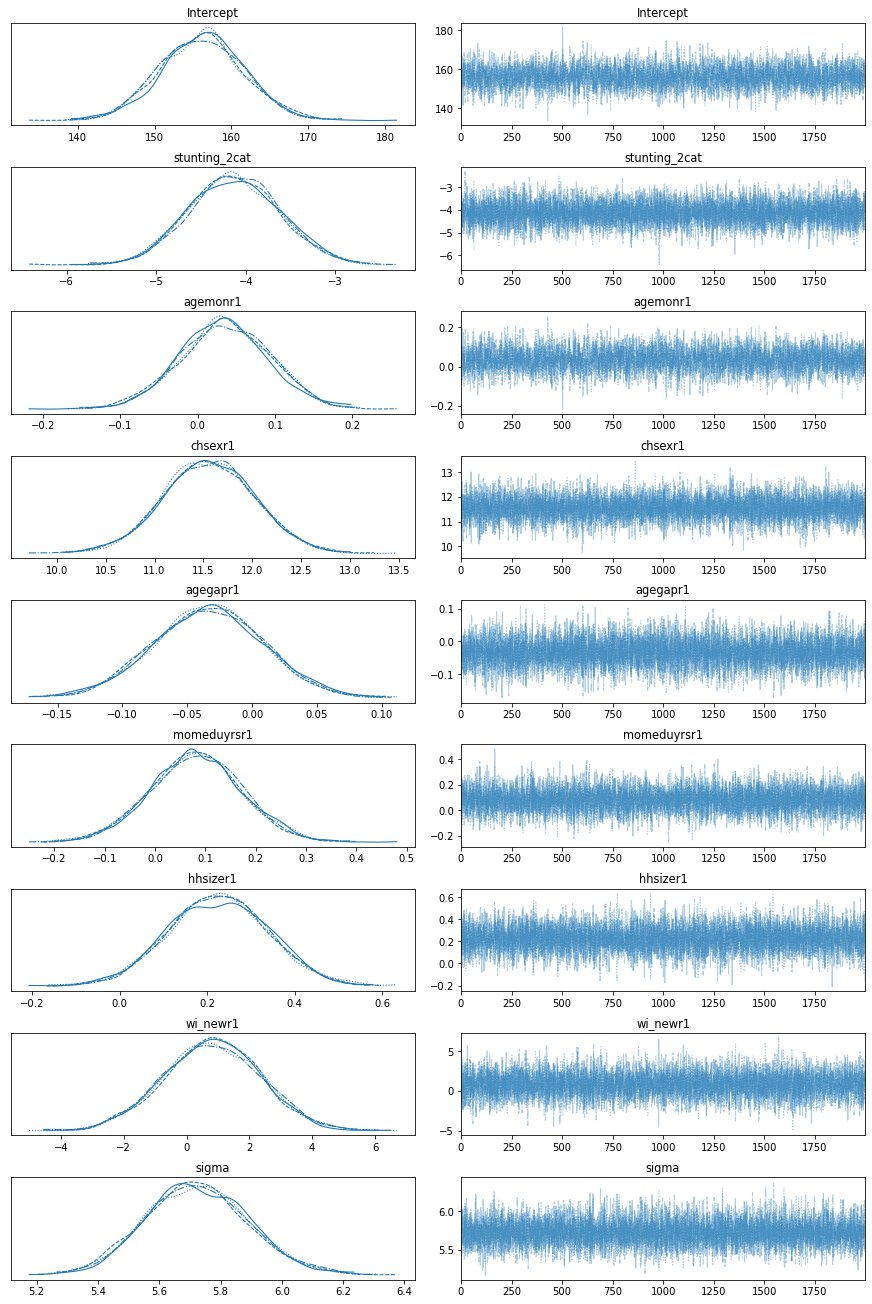

In [38]:
az.plot_trace(linear_trace)

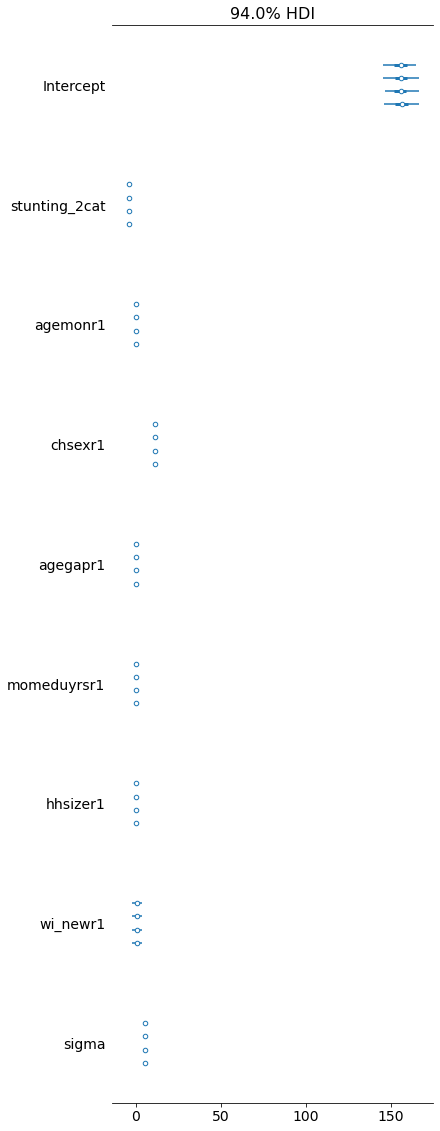

In [39]:
az.plot_forest(linear_trace);